# Data Understanding

The dataset is TrashNet in this project. The dataset consists of 6 different classes. The dataset contains a total of 2527 images, categorized into six classes: glass, paper, cardboard, plastic, metal, and trash.

The distribution of images is as follows:

- 501 glass  
- 594 paper  
- 403 cardboard  
- 482 plastic  
- 410 metal  
- 137 trash

The images were taken by placing items on a whiteboard and using either sunlight or room lighting. Each image has a resolution of 512 x 384 pixels with 3 RGB channels.

In [1]:
# pip install imutils

# reading and processing data
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

# ignore warnings

import warnings
warnings.filterwarnings('ignore')

# model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# modelling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img


# Google Colab Link

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading the dataset

In [86]:
dir_path = '/content/drive/MyDrive/Garbage classification'

Target Size and Label Values

In [4]:
target_size = (224,224)

waste_labels = {'cardboard':0, 'glass':1, 'metal':2, 'paper':3, 'plastic':4, 'trash':5}

In [5]:
def load_datasets(path):
  """
  It reads the images in the directory and creates their labels.

  Parameters:
  path: Refers to the directory where the images are located.

  Return:

  x: It stores the matrix information of the images.

  labels: A list that holds the class information of each image.

  """
  x = []
  labels = []

  # It lists and sorts the images in the specified path
  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    # The images in the specified path are read using the OpenCV library
    img = cv2.imread(image_path)

    # The read images are resized to the predefined target size
    img = cv2.resize(img, target_size)

    # The resized images are added to the x list
    x.append(img)

    # When each path is split by '/', the second-to-last element of the resulting list represents the label
    label = image_path.split(os.path.sep)[-2]

    # The label is created by retrieving the corresponding value for the given key from the `waste_labels`
    # dictionary, which contains the numerical representations of the captured labels
    labels.append(waste_labels[label])

  # The dataset is shuffled randomly
  x, labels = shuffle(x, labels, random_state= 42)

  # About size and class information
  print(f'X size: {np.array(x).shape}')
  print(f'Number of label classes: {len(np.unique(labels))} Number of observations: {len(labels)}')

  return x, labels


In [6]:
x, labels = load_datasets(dir_path)

X size: (2536, 224, 224, 3)
Number of label classes: 6 Number of observations: 2536


In [7]:
# Storing the image size

input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


# Samples from the Dataset

In [8]:
def visualize_img(image_batch, label_batch):
  """
  Parameters:

  image_batch: Storing the matrix information of the images

  label_batch: A list that stores the class information of the image

  """
  plt.figure(figsize=(10,10))
  for n in range(10):
    ax= plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys())) [to_categorical(labels, num_classes=6)[n]==1][0].title())
    plt.axis('off')


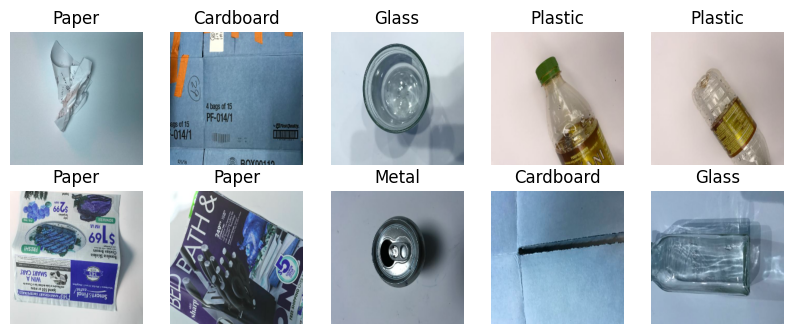

In [9]:
visualize_img(x, labels)

# Data Preparation

In [10]:
# Define a generator for the train dataset

train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range= 0.1,
                           zoom_range= 0.1,
                           width_shift_range = 0.1,
                           height_shift_range = 0.1)


# Define a generator for the test dataset

test = ImageDataGenerator(rescale= 1./255,
                          validation_split= 0.1)


In [11]:
train_generator = train.flow_from_directory(directory=dir_path,
                                            target_size = (target_size),
                                            class_mode = 'categorical',
                                            subset = 'training')

test_generator = test.flow_from_directory(directory=dir_path,
                                            target_size = (target_size),
                                            batch_size = 251,
                                            class_mode = 'categorical',
                                            subset = 'validation')


Found 2284 images belonging to 6 classes.
Found 252 images belonging to 6 classes.


# Modeling


**Building a CNN Model from Scratch**


*   Sequential
*   Convolution Layer, Conv2D
*   Pooling Layer
*   Activation Layer
*   Flattening Layer
*   Dense Layer
*   Dropout Layer









In [12]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding = 'same', input_shape=(input_shape), activation = 'relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding = 'same', input_shape=(input_shape), activation = 'relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding = 'same', input_shape=(input_shape), activation = 'relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation='softmax'))


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

# Optimization and Adjustment of Evaluation Metrics

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

In [15]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=50,
                           verbose=1,
                           mode="min"),

             ModelCheckpoint(filepath='mymodel.keras',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)]

# Training the Model

In [21]:
history = model.fit(train_generator,
                              epochs=100,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              steps_per_epoch=2284//32,
                              validation_steps=252//32)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.2337 - loss: 1.7331 - precision: 0.3972 - recall: 0.0032
Epoch 1: val_loss improved from inf to 1.62017, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - acc: 0.2341 - loss: 1.7324 - precision: 0.3994 - recall: 0.0035 - val_acc: 0.2659 - val_loss: 1.6202 - val_precision: 0.8889 - val_recall: 0.0317
Epoch 2/100
 1/71 ━━━━━━━━━━━━━━━━━━━━ 3:04 3s/step - acc: 0.2812 - loss: 1.5483 - precision: 1.0000 - recall: 0.0312
Epoch 2: val_loss did not improve from 1.62017
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - acc: 0.2812 - loss: 1.5483 - precision: 1.0000 - recall: 0.0312 - val_acc: 0.2579 - val_loss: 1.6216 - val_precision: 1.0000 - val_recall: 0.0198
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.3384 - loss: 1.5634 - precision: 0.6062 - recall: 0.0687
Epoch 3: val_loss improved from 1.62017 to 1.44289, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - acc: 0.3388 - loss: 1.5

# Accuracy & Loss Graph

Text(0.5, 1.0, 'Training and Validation Loss')

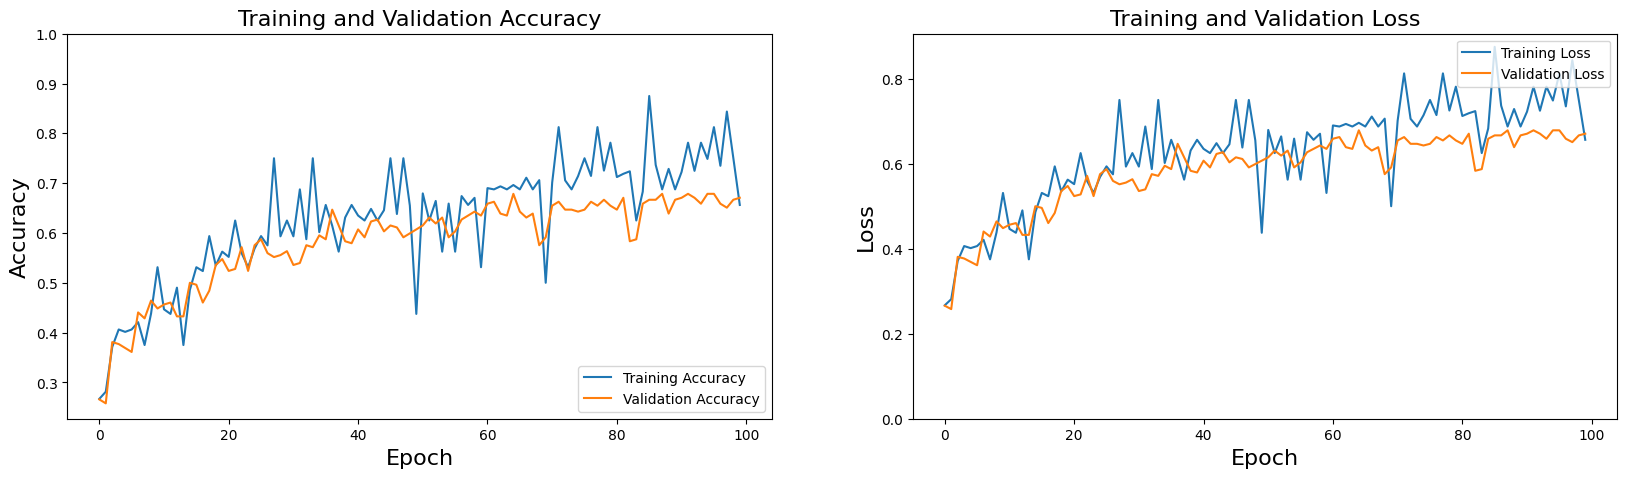

In [22]:
# Accuracy Graph

plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy' , fontsize=16)



# Loss Graph

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Loss')
plt.plot(history.history['val_acc'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss' , fontsize=16)


# Evaluation

In [23]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - acc: 0.6702 - loss: 0.9639 - precision: 0.7929 - recall: 0.5629


In [24]:
print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (100.0 * loss))
print("\nTest precision: %.1f%%" % (100.0 * precision))
print("\nTest recall: %.1f%%" % (100.0 * recall))


Test accuracy: 67.1%

Test loss: 96.3%

Test precision: 79.3%

Test recall: 56.3%


# Classification Report

In [32]:
x_test, y_test = next(test_generator)

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 758ms/step


In [33]:
target_names = list(waste_labels.keys())
print("Target names:", target_names)


print("Unique classes in y_test:", np.unique(y_test))
print("Unique classes in y_pred:", np.unique(y_pred))

Target names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Unique classes in y_test: [0 1 2 3 4 5]
Unique classes in y_pred: [0 1 2 3 4 5]


In [34]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.56      0.70      0.62        40
       glass       0.62      0.74      0.67        50
       metal       0.57      0.60      0.59        40
       paper       0.89      0.92      0.90        59
     plastic       0.79      0.31      0.44        49
       trash       0.53      0.77      0.62        13

    accuracy                           0.67       251
   macro avg       0.66      0.67      0.64       251
weighted avg       0.69      0.67      0.66       251



# Confusion Matrix

In [40]:
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'.
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm [i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label', fontweight="bold")
  plt.xlabel('Predicted label', fontweight="bold")


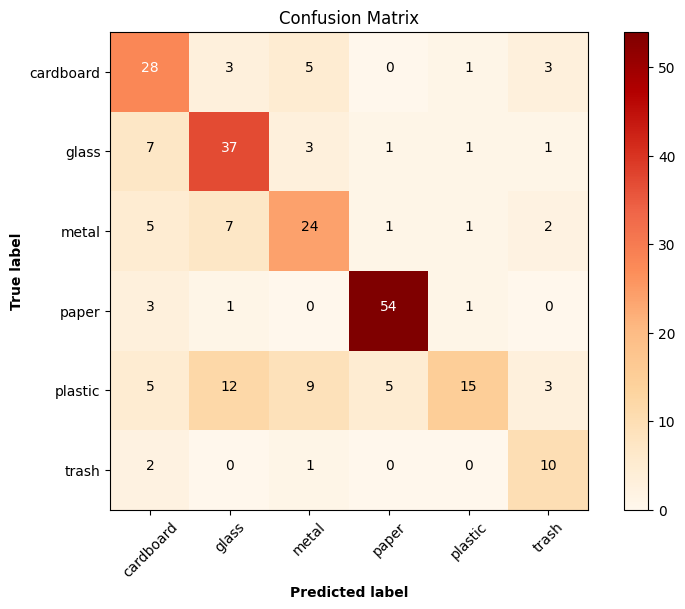

In [41]:
plot_confusion_matrix(cm, waste_labels.keys(),
                          title='Confusion Matrix',
                          cmap=plt.cm.OrRd)

# Test

In [42]:
waste_labels= {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash' }

In [83]:
def model_testing(path):
  """
  The image in the specified directory is read,
  and a prediction is made via the model to determine which class it belongs to.

  Parameters:
  path: indicates the directory where the image is located

  Return:
  img: image
  p: prediction probabilities
  predicted_class: prediction class
  """

  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img) / 255.0
  p = model.predict(img.reshape(1, 224, 224, 3))
  predicted_class = np.argmax(p[0])

  return img, p, predicted_class

In [94]:
img1, p1, predicted_class1 = model_testing ('/content/drive/MyDrive/Garbage classification/metal/metal9.jpg')
img2, p2, predicted_class2 = model_testing ('/content/drive/MyDrive/Garbage classification/glass/glass100.jpg')
img3, p3, predicted_class3 = model_testing ('/content/drive/MyDrive/Garbage classification/cardboard/cardboard105.jpg')
img4, p4, predicted_class4 = model_testing ('/content/drive/MyDrive/Garbage classification/paper/paper108.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


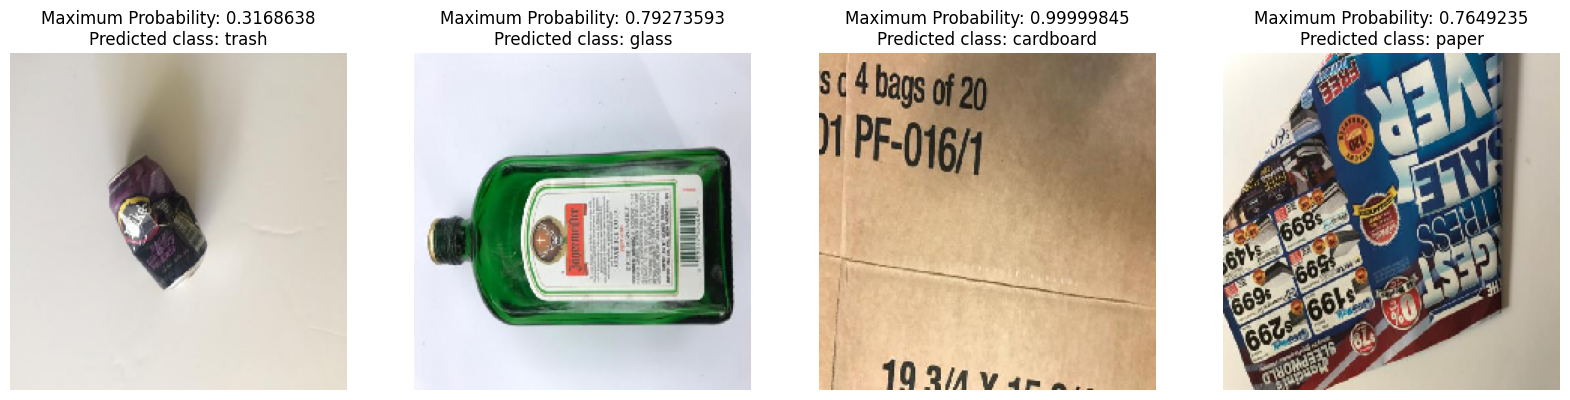

In [95]:
plt.figure(figsize=(20,60))

plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p1[0], axis=-1)) + "\n" + "Predicted class: " +str(waste_labels[predicted_class1]))
plt.imshow(img1);

plt.subplot(142)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p2[0], axis=-1)) + "\n" + "Predicted class: " +str(waste_labels[predicted_class2]))
plt.imshow(img2);

plt.subplot(143)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p3[0], axis=-1)) + "\n" + "Predicted class: " +str(waste_labels[predicted_class3]))
plt.imshow(img3);

plt.subplot(144)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p4[0], axis=-1)) + "\n" + "Predicted class: " +str(waste_labels[predicted_class4]))
plt.imshow(img4);
